In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.cluster.hierarchy as sch

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
# Set plot style
sns.set_style('whitegrid')

In [30]:
!git clone "https://github.com/GeeksforgeeksDS/21-Days-21-Projects-Dataset"

fatal: destination path '21-Days-21-Projects-Dataset' already exists and is not an empty directory.


In [31]:
df = pd.read_csv('21-Days-21-Projects-Dataset/Datasets/Mall_Customers.csv')
print("Dataset loaded successfully.")
print(f"Data shape: {df.shape}")
df.head()

Dataset loaded successfully.
Data shape: (200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


## EDA

In [32]:
# Basic info and statistics
print("Dataset Info:")
df.info()

# Drop the CustomerID as it's just an identifier and not useful for clustering
df.drop('CustomerID', axis=1, inplace=True)

print("\nDescriptive Statistics:")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB

Descriptive Statistics:
              Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000          200.000000              200.000000
mean    38.850000           60.560000               50.200000
std     13.969007           26.264721               25.823522
min     18.000000           15.000000                1.000000
25%     28.750000           41.500000               34.750000
50%     36.000000           61.500000               50.000000
75%     4

### Univariate Analysis

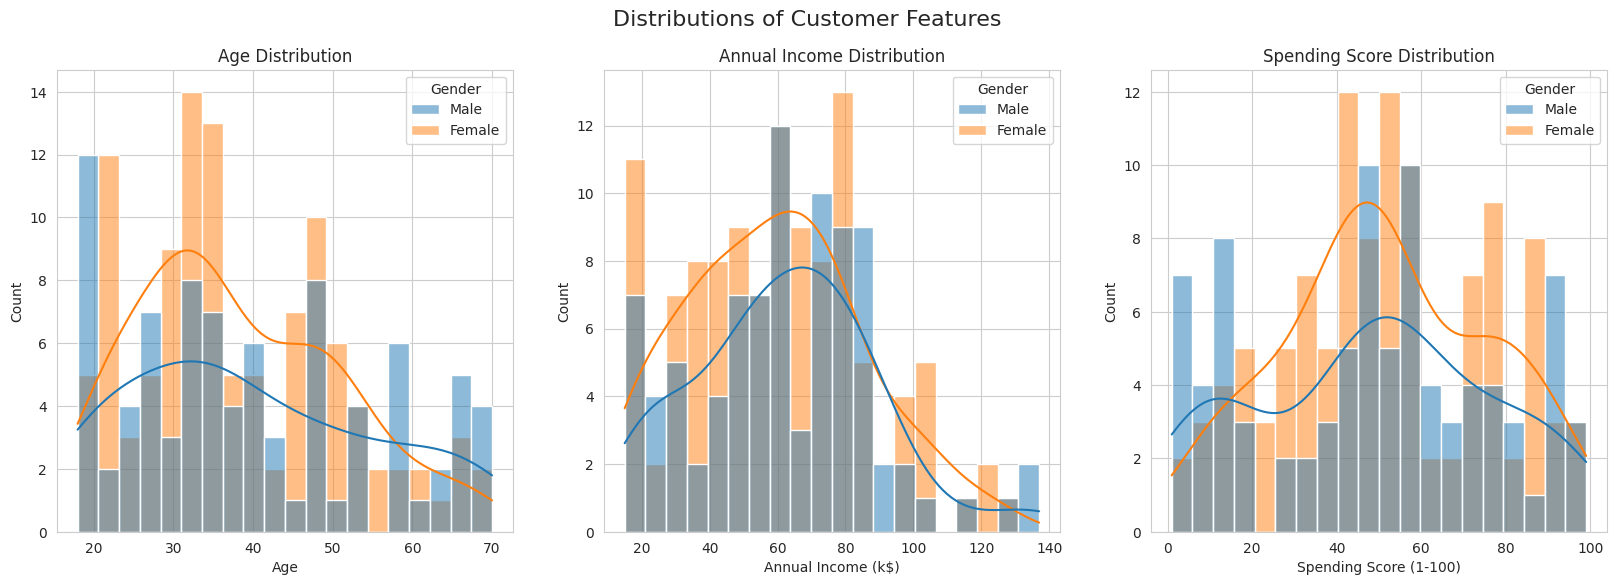

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Distributions of Customer Features', fontsize=16)

sns.histplot(ax=axes[0], data=df, x='Age', kde=True, bins=20, hue='Gender').set_title('Age Distribution')
sns.histplot(ax=axes[1], data=df, x='Annual Income (k$)', kde=True, bins=20, hue='Gender').set_title('Annual Income Distribution')
sns.histplot(ax=axes[2], data=df, x='Spending Score (1-100)', kde=True, bins=20, hue='Gender').set_title('Spending Score Distribution')

plt.show()

### Bivariate Analysis

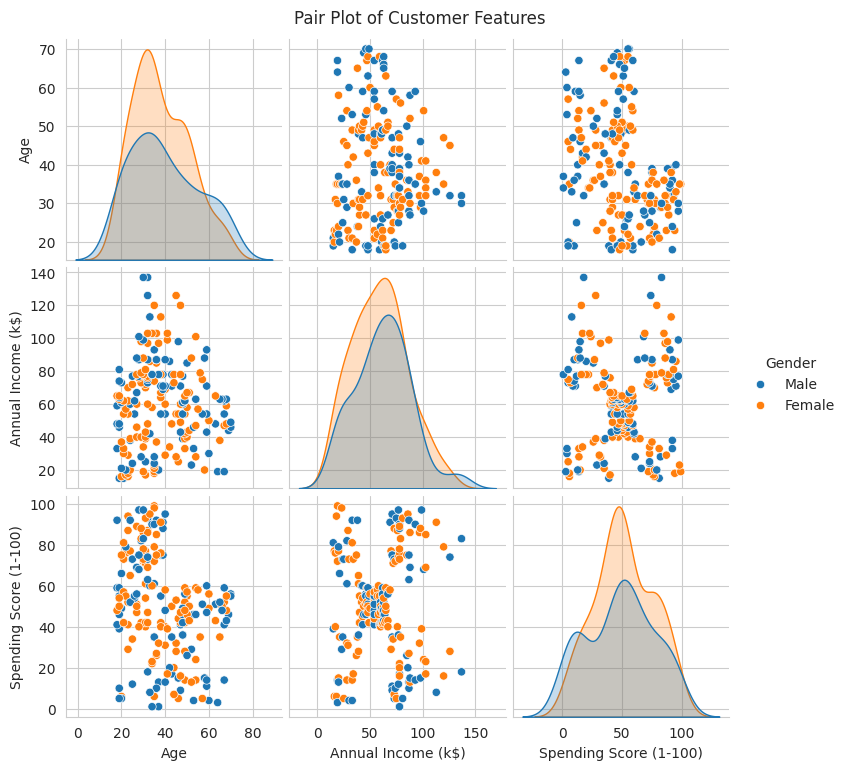

In [34]:
# Using pairplot to visualize relationships between all numerical variables
sns.pairplot(df, vars=['Age', 'Annual Income (k$)', 'Spending Score (1-100)'], hue='Gender', diag_kind='kde')
plt.suptitle('Pair Plot of Customer Features', y=1.02)
plt.show()

### Inference:
- Annual income vs Spending score: shows distinct groups
- Age vs Spending score: high-spending customers in younger age brackets
- Gender: largly overlaps (not a strong seperating feature)

In [35]:
fig = px.scatter_3d(df,
                    x='Annual Income (k$)',
                    y='Spending Score (1-100)',
                    z='Age',
                    color='Gender',
                    title='3D View of Customer Data')
fig.show()

### Segmentation Model 1: Income and Spending Score

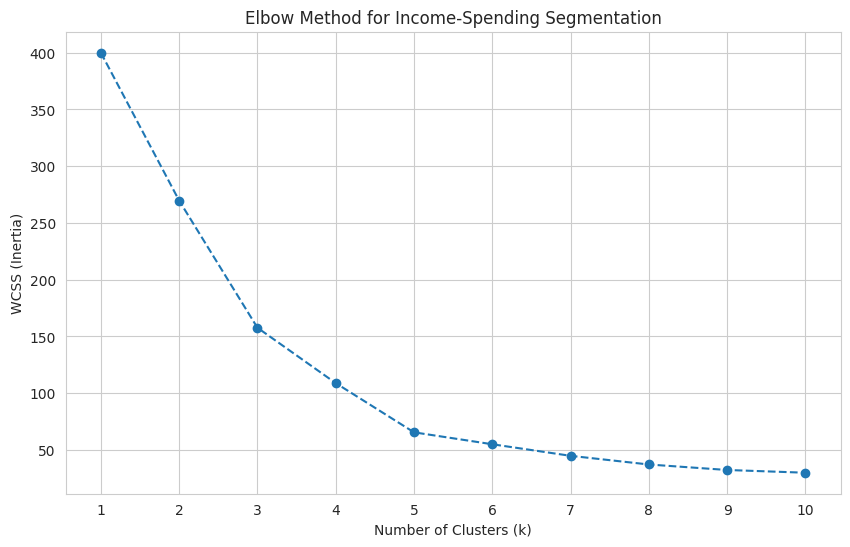

In [36]:
# 1. Select and scale the features
X1 = df[['Annual Income (k$)', 'Spending Score (1-100)']]
scaler1 = StandardScaler()
X1_scaled = scaler1.fit_transform(X1)

# 2. Implement the Elbow Method
wcss1 = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X1_scaled)
    wcss1.append(kmeans.inertia_)

# 3. Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss1, marker='o', linestyle='--')
plt.title('Elbow Method for Income-Spending Segmentation')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range(1, 11))
plt.show()

### Inference:
- The "elbow" of the curve is at k=5. (The WCSS decreases sharply until k=5, and then the rate of decrease flattens out)

In [37]:
# Build and fit the final model
kmeans1 = KMeans(n_clusters=5, init='k-means++', random_state=42, n_init=10)
df['Income_Cluster'] = kmeans1.fit_predict(X1_scaled)

### Visualizing and Interpreting the Income-Based Segments

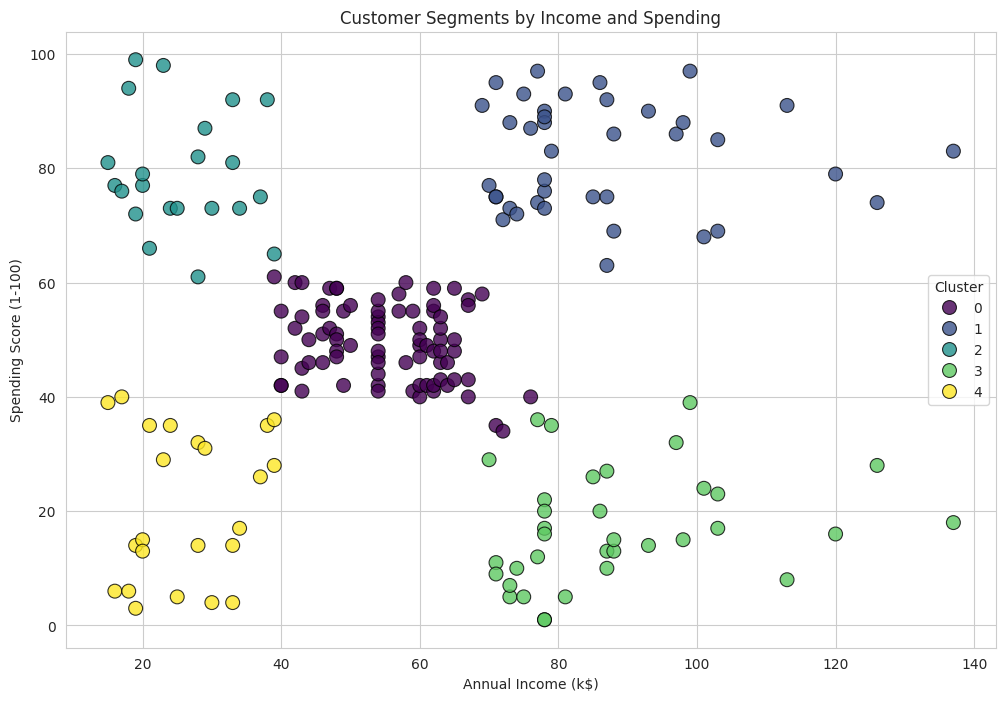

In [38]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)',
                hue='Income_Cluster', palette='viridis', s=100, alpha=0.8, edgecolor='black')
plt.title('Customer Segments by Income and Spending')
plt.legend(title='Cluster')
plt.show()

In [39]:
# Quantitative Persona Analysis
cluster_profiles1 = df.groupby('Income_Cluster')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean().round(2)
cluster_profiles1['Size'] = df['Income_Cluster'].value_counts()
print("--- Income-Based Cluster Profiles ---")
cluster_profiles1

--- Income-Based Cluster Profiles ---


,Age,Annual Income (k$),Spending Score (1-100),Size
Income_Cluster,,,,
0,42.72,55.30,49.52,81
1,32.69,86.54,82.13,39
2,25.27,25.73,79.36,22
3,41.11,88.20,17.11,35
4,45.22,26.30,20.91,23


### Inferenece:
- Cluster 0: Major people lies in category of mid-income and mid-expense.
- Cluster 1: moderate people are there in category of high-income and high-expense.
- Cluster 2: less people lies in the category of low-income but high-expense.
- Cluster 3: moderate people are there in the category of high-income and less-expense.
- Cluster 4: less poeple lies under category of low-income and low-expense.

### Segmentation Model 2: Age and Spending Score

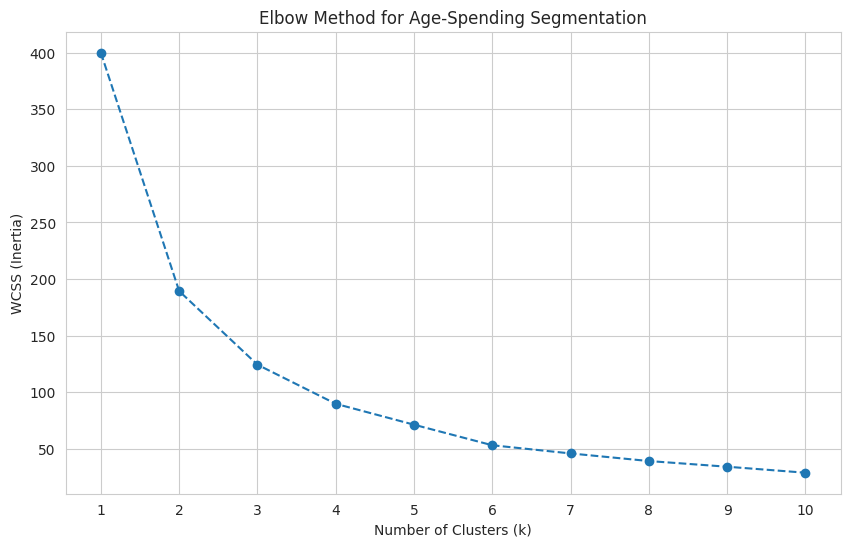

In [40]:
# 1. Select and scale the features
X2 = df[['Age', 'Spending Score (1-100)']]
scaler2 = StandardScaler()
X2_scaled = scaler2.fit_transform(X2)

# 2. Implement the Elbow Method
wcss2 = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X2_scaled)
    wcss2.append(kmeans.inertia_)

# 3. Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss2, marker='o', linestyle='--')
plt.title('Elbow Method for Age-Spending Segmentation')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range(1, 11))
plt.show()

### Inference:
- The elbow is less sharp here, but **k=4** appears to be a reasonable choice.

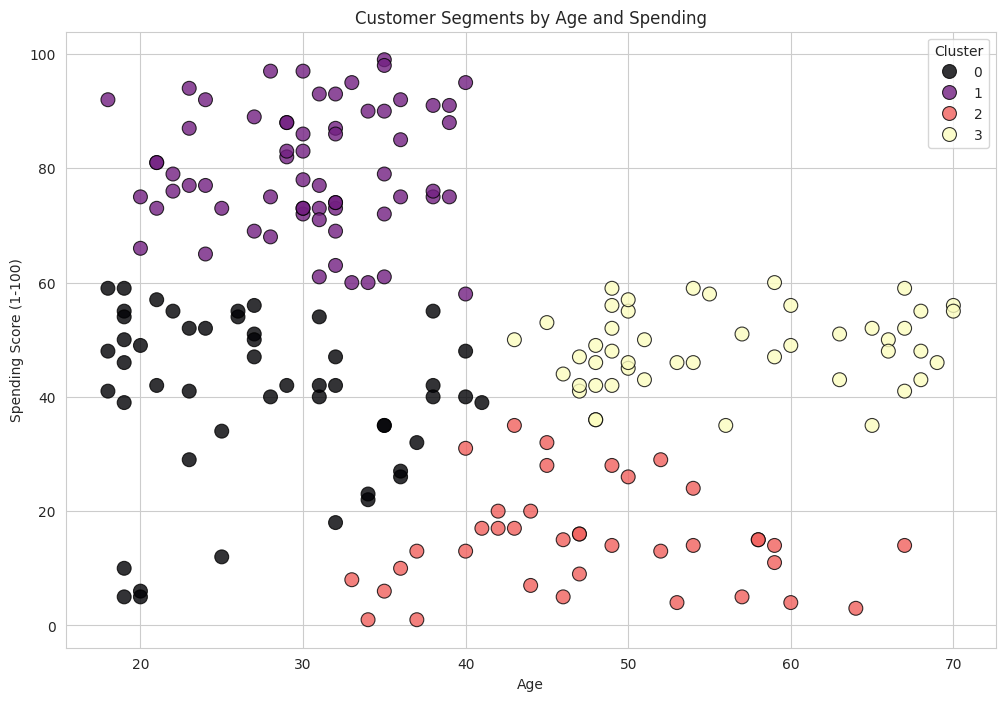

In [41]:
# Build and fit the final model for age segmentation
kmeans2 = KMeans(n_clusters=4, init='k-means++', random_state=42, n_init=10)
df['Age_Cluster'] = kmeans2.fit_predict(X2_scaled)

# Visualize the new clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Age', y='Spending Score (1-100)',
                hue='Age_Cluster', palette='magma', s=100, alpha=0.8, edgecolor='black')
plt.title('Customer Segments by Age and Spending')
plt.legend(title='Cluster')
plt.show()

### Inference:
- Young High-Spenders: A clear group of customers under 40 with high spending scores.
- Young Low-Spenders: Customers under 40 with low-to-moderate spending.
- Older Average-Spenders: Customers over 40 with moderate spending scores.
- Older Low-Spenders: A small group of older customers with very low spending scores.

### Hierarchial Clustering

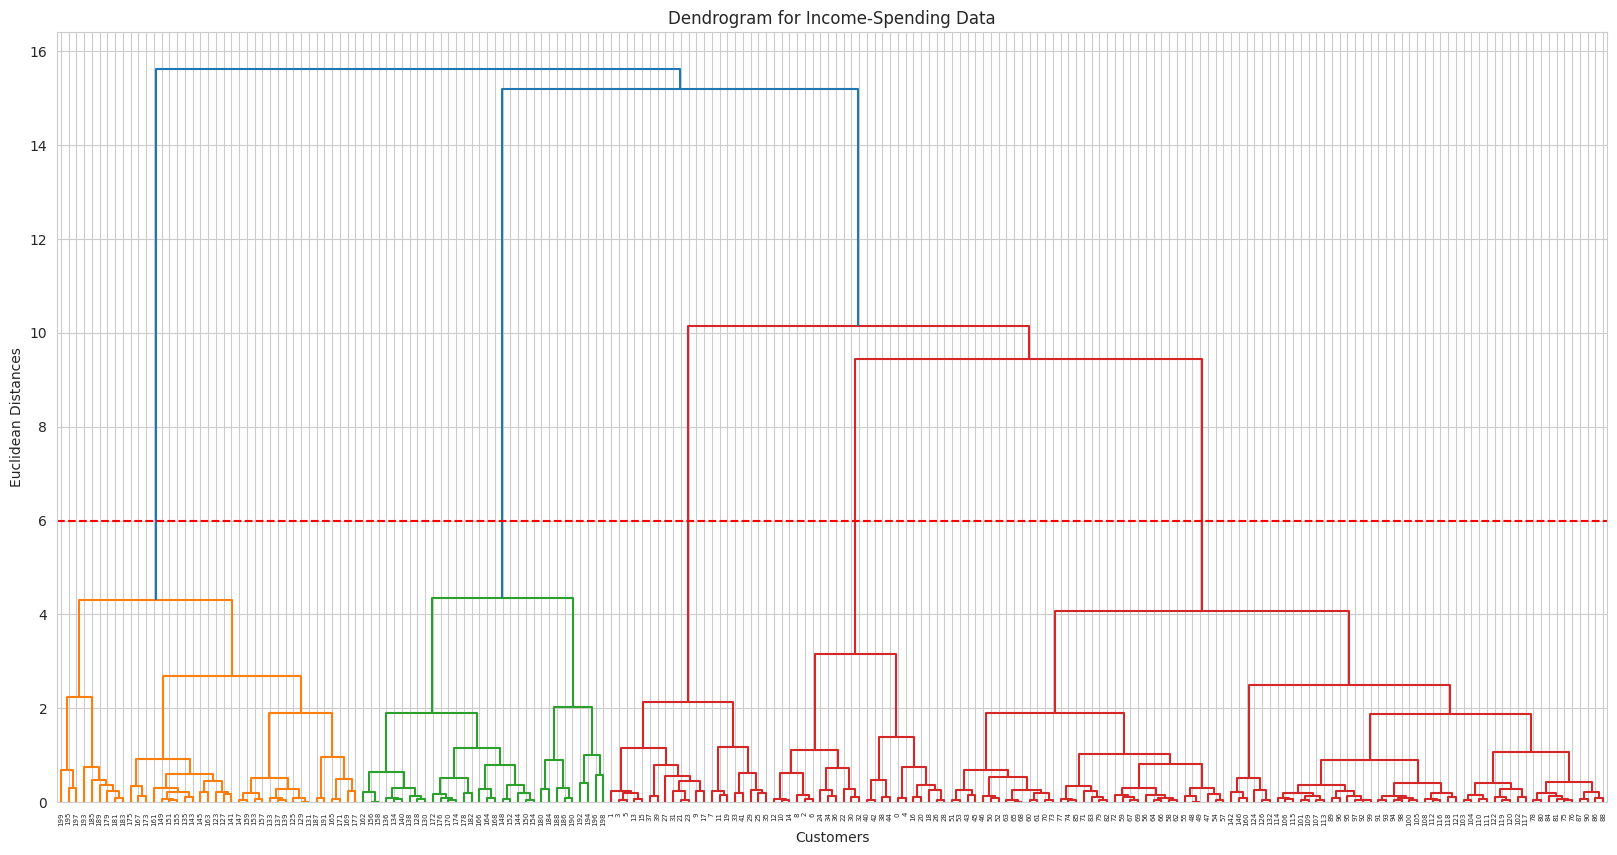

In [42]:
plt.figure(figsize=(20, 10))
dendrogram = sch.dendrogram(sch.linkage(X1_scaled, method='ward'))
plt.title('Dendrogram for Income-Spending Data')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distances')
plt.axhline(y=6, color='r', linestyle='--') # Example cut-off line
plt.show()

### Assignments:

1.  **Explore Gender vs. Spending Score:** Analyze the relationship between 'Gender' and 'Spending Score (1-100)' to see if gender plays a significant role in spending habits. Visualizations and summary statistics would be helpful here.
2.  **Apply Feature Engineering for Clustering:** Create a new feature using existing data (Feature Engineering). Then, explore if clustering can be effectively performed using this newly engineered feature in combination with one or more existing features. Document the feature engineering process, the chosen features for clustering, the determination of the optimal number of clusters (e.g., using the Elbow Method), and the resulting cluster visualization and interpretation.

1

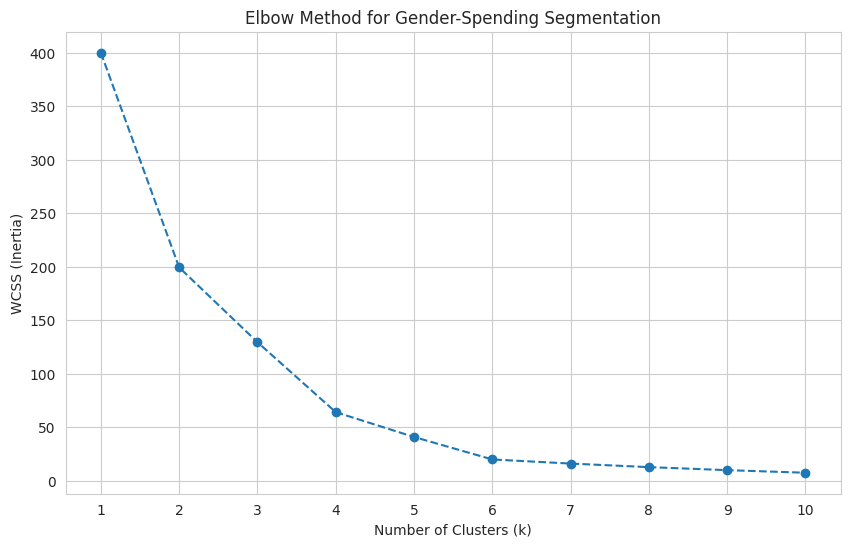

In [43]:
# 1. Select the features and handle categorical variable (Gender)
X3 = df[['Gender', 'Spending Score (1-100)']]
X3 = pd.get_dummies(X3, columns=['Gender'], drop_first=True) # One-hot encode Gender

# 2. Scale the features
scaler3 = StandardScaler()
X3_scaled = scaler3.fit_transform(X3)

# 3. Implement the Elbow Method
wcss3 = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X3_scaled)
    wcss3.append(kmeans.inertia_)

# 4. Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss3, marker='o', linestyle='--')
plt.title('Elbow Method for Gender-Spending Segmentation')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range(1, 11))
plt.show()

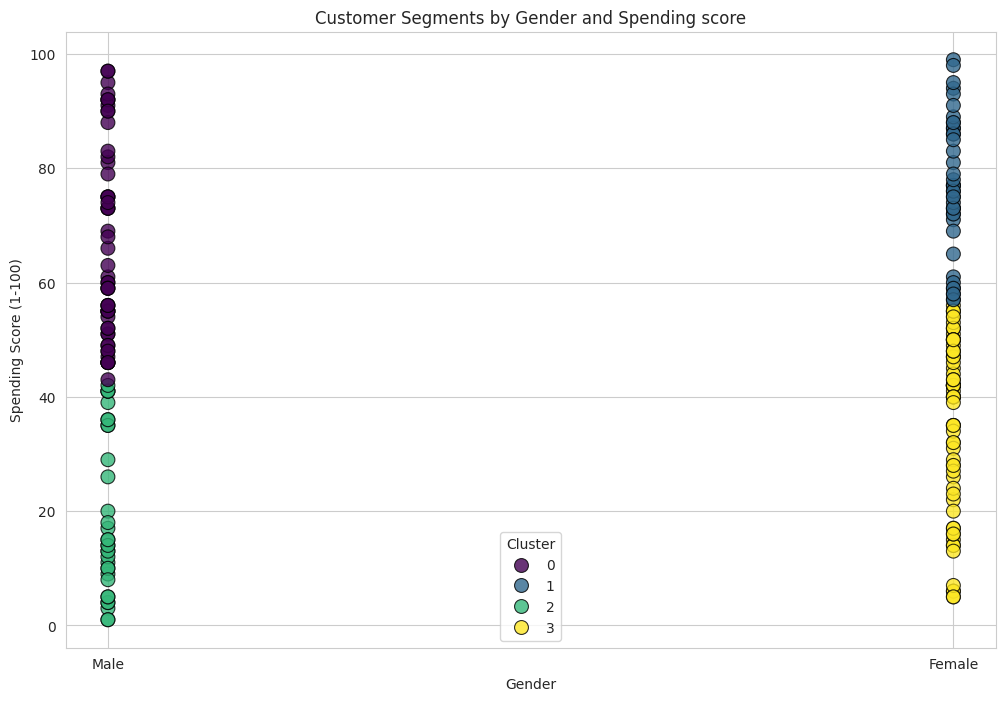

In [44]:
# Build and fit the final model for gender segmentation
kmeans3 = KMeans(n_clusters=4, init='k-means++', random_state=42, n_init=10)
df['Gender_Cluster'] = kmeans3.fit_predict(X3_scaled)

# Visualize the new clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Gender', y='Spending Score (1-100)',
                hue='Gender_Cluster', palette='viridis', s=100, alpha=0.8, edgecolor='black')
plt.title('Customer Segments by Gender and Spending score')
plt.legend(title='Cluster')
plt.show()

2

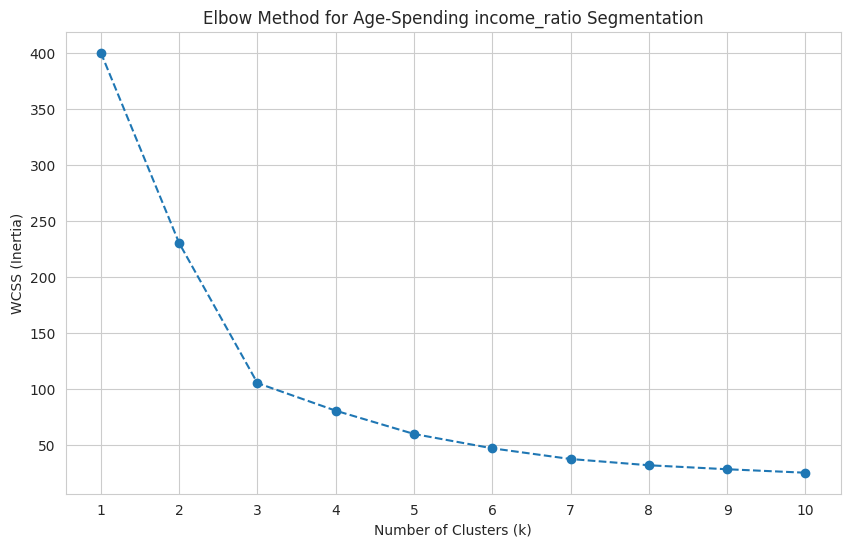

In [45]:
df['Spending_income_ratio'] = df['Spending Score (1-100)'] / (df['Annual Income (k$)'] + 1e-6)

X5 = df[['Age', 'Spending_income_ratio']]

scaler5 = StandardScaler()
X5_scaled = scaler5.fit_transform(X5)

wcss5 = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X5_scaled)
    wcss5.append(kmeans.inertia_)

# 5. Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss5, marker='o', linestyle='--')
plt.title('Elbow Method for Age-Spending income_ratio Segmentation')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range(1, 11))
plt.show()

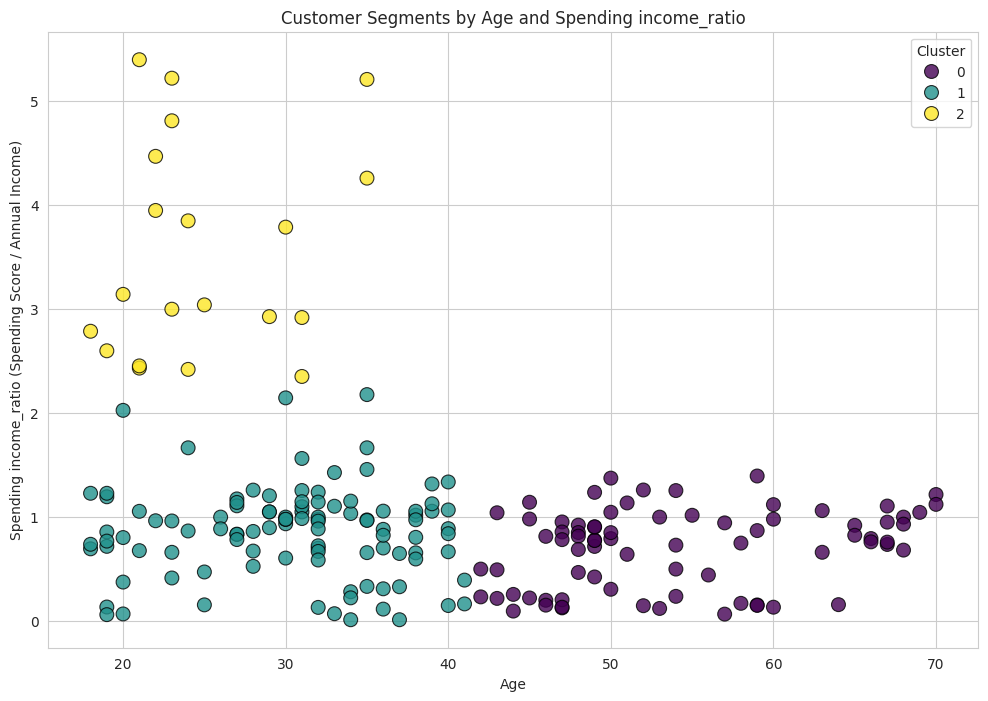

In [46]:
# Build and fit the final model for age-spending income_ratio segmentation
kmeans5 = KMeans(n_clusters=3, init='k-means++', random_state=42, n_init=10)
df['Age_Spending_income_ratio_Cluster'] = kmeans5.fit_predict(X5_scaled)

# Visualize the new clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Age', y='Spending_income_ratio',
                hue='Age_Spending_income_ratio_Cluster', palette='viridis', s=100, alpha=0.8, edgecolor='black')
plt.title('Customer Segments by Age and Spending income_ratio')
plt.xlabel('Age')
plt.ylabel('Spending income_ratio (Spending Score / Annual Income)')
plt.legend(title='Cluster')
plt.show()

There are 3 distinct clusters that are formed
- Younger high spend-income ratio customers
- Younger low spend-income ratio customers
- Older low spend-income ratio customers

# Task
Create 5 new features from the dataframe, then for each new feature, determine the optimal number of clusters using the Elbow method and plot the Elbow curve. After finding the optimal number of clusters, apply K-Means clustering and plot a scatter plot of the clusters for each feature.

## Feature engineering

### Subtask:
Create five new features based on the existing columns in the DataFrame.


**Reasoning**:
Creating five new features based on the existing columns as requested by the instructions.



In [52]:
# 1. Create Income_to_Age_Ratio
df['Income_to_Age_Ratio'] = df['Annual Income (k$)'] / (df['Age'] + 1e-6)

# 2. Create Spending_to_Age_Ratio
df['Spending_to_Age_Ratio'] = df['Spending Score (1-100)'] / (df['Age'] + 1e-6)

# 3. Create Income_and_Spending_Score
df['Income_and_Spending_Score'] = df['Annual Income (k$)'] + df['Spending Score (1-100)']

# 4. Create Age_multiplied_by_Spending
df['Age_multiplied_by_Spending'] = df['Age'] * df['Spending Score (1-100)']

# 5. Create Income_minus_Spending
df['Income_minus_Spending'] = df['Annual Income (k$)'] - df['Spending Score (1-100)']

display(df.head())

,Gender,Age,Annual Income (k$),Spending Score (1-100),Income_Cluster,Age_Cluster,Gender_Cluster,Spending_income_ratio,Age_Spending_income_ratio_Cluster,Income_to_Age_Ratio,Spending_to_Age_Ratio,Income_and_Spending_Score,Age_multiplied_by_Spending,Income_minus_Spending,Income_to_Age_Ratio_Cluster,Spending_to_Age_Ratio_Cluster,Income_and_Spending_Score_Cluster,Age_multiplied_by_Spending_Cluster,Income_minus_Spending_Cluster
0,Male,19,15,39,4,0,2,2.600000,2,0.789474,2.052631,54,741,-24,1,1,2,1,0
1,Male,21,15,81,2,1,0,5.400000,2,0.714286,3.857143,96,1701,-66,1,2,1,2,2
2,Female,20,16,6,4,0,3,0.375000,1,0.800000,0.300000,22,120,10,1,0,2,1,0
3,Female,23,16,77,2,1,1,4.812500,2,0.695652,3.347826,93,1771,-61,1,2,1,2,2
4,Female,31,17,40,4,0,3,2.352941,2,0.548387,1.290323,57,1240,-23,1,0,2,1,0


## Iterate through new features

### Subtask:
For each new feature, determine the optimal number of clusters using the Elbow method and plot the Elbow curve. After finding the optimal number of clusters, apply K-Means clustering and plot a scatter plot of the clusters for each feature.


**Reasoning**:
Create a list of the new feature names and dictionaries to store scaled features, WCSS values, optimal k values, fitted KMeans models, and cluster labels as per the instructions. Then iterate through the new features, scale them, calculate WCSS for k from 1 to 10, and store the results.



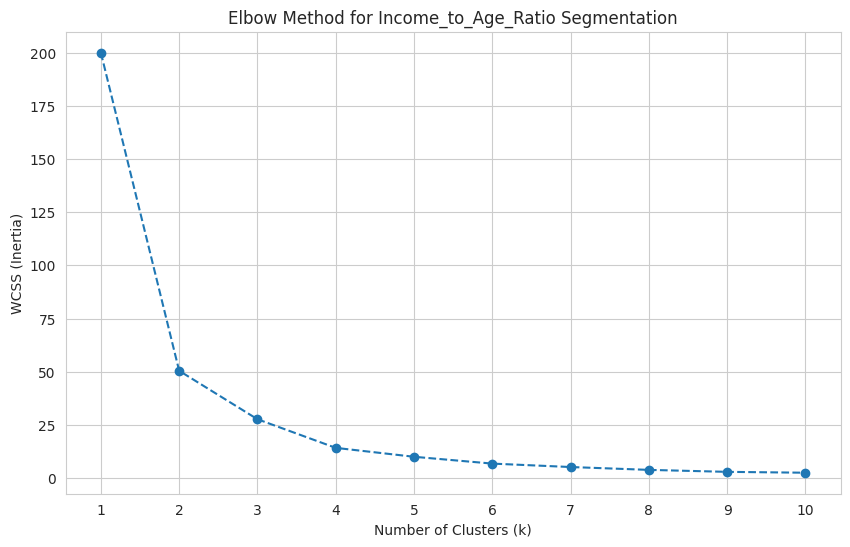

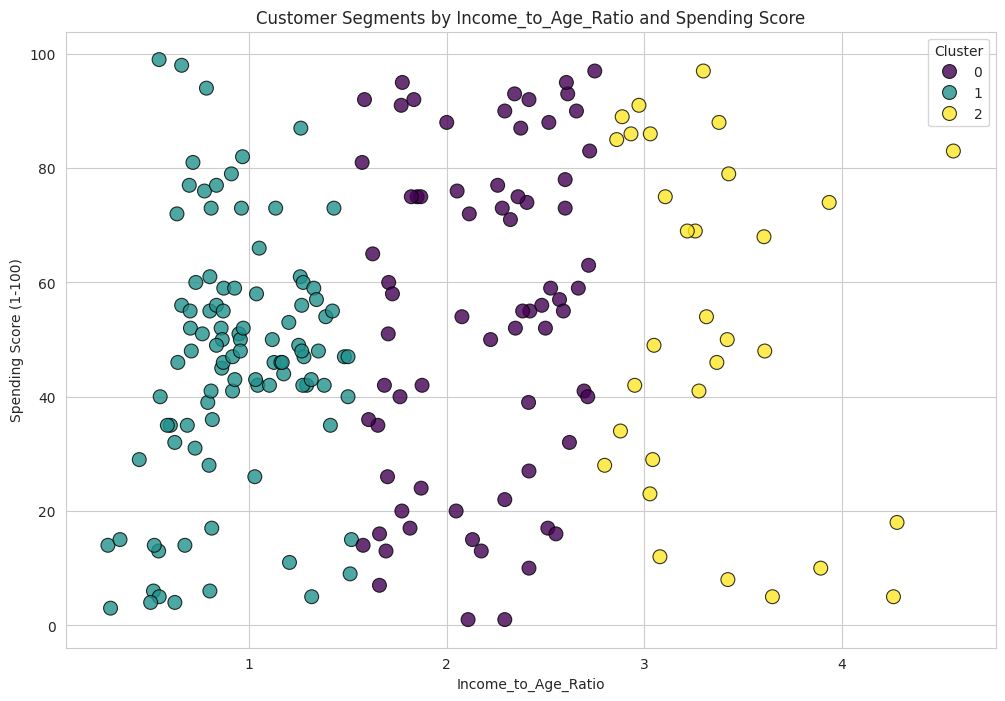

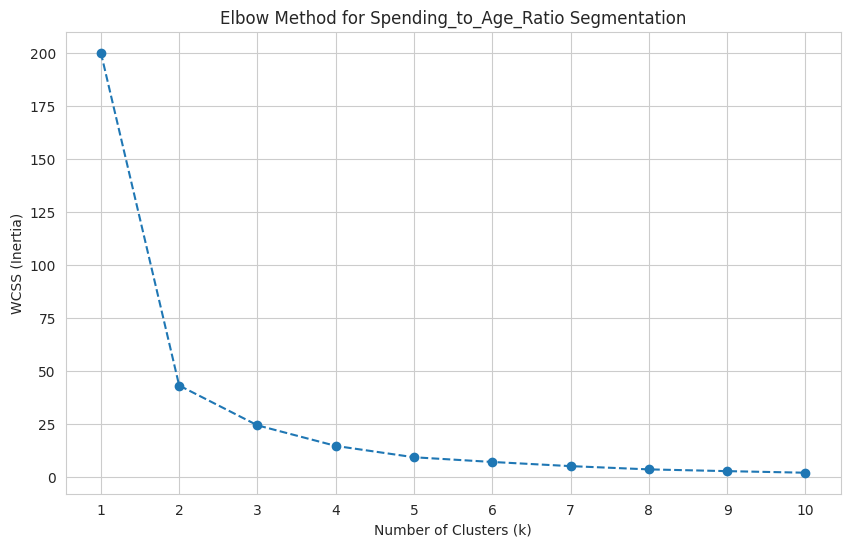

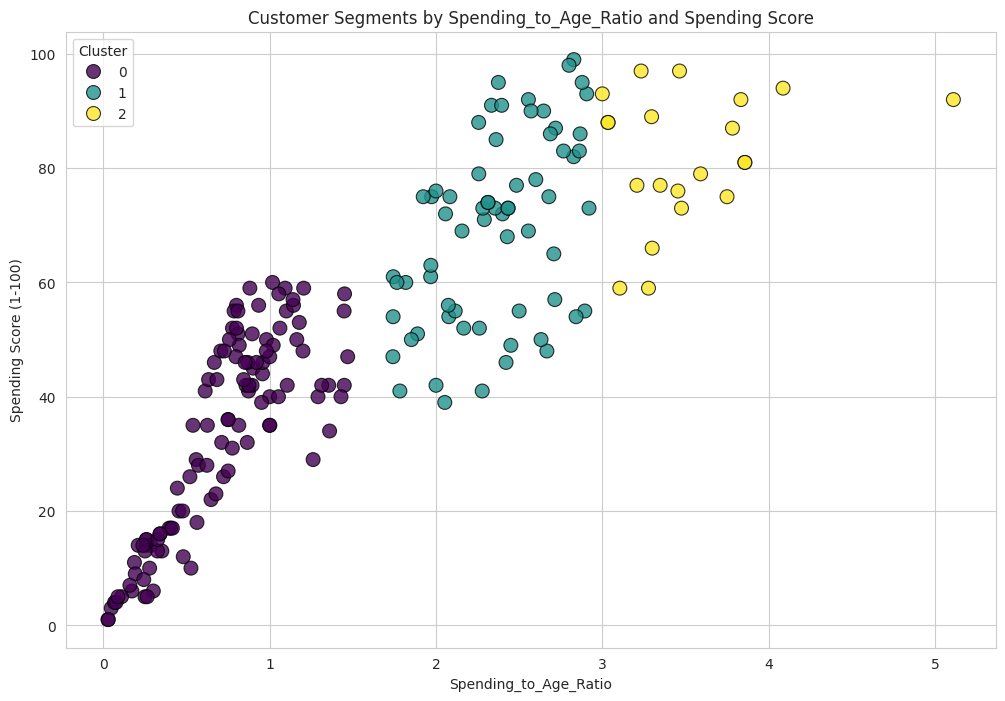

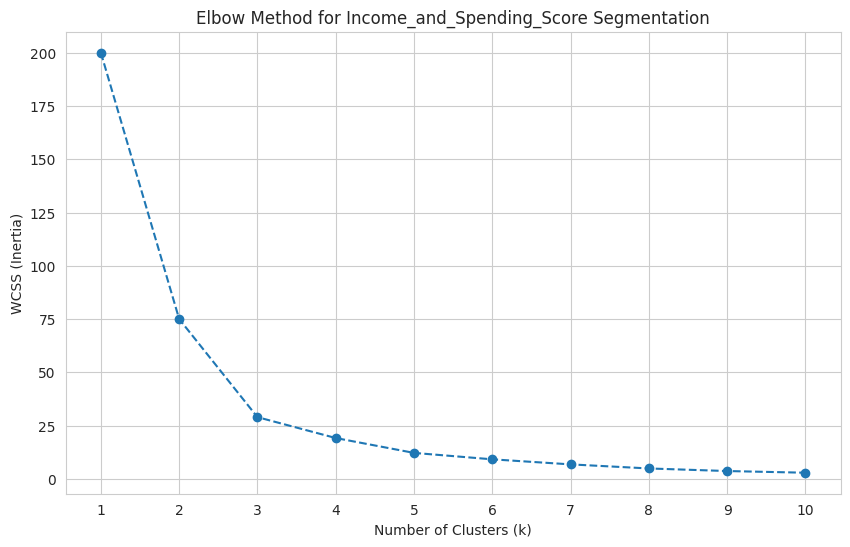

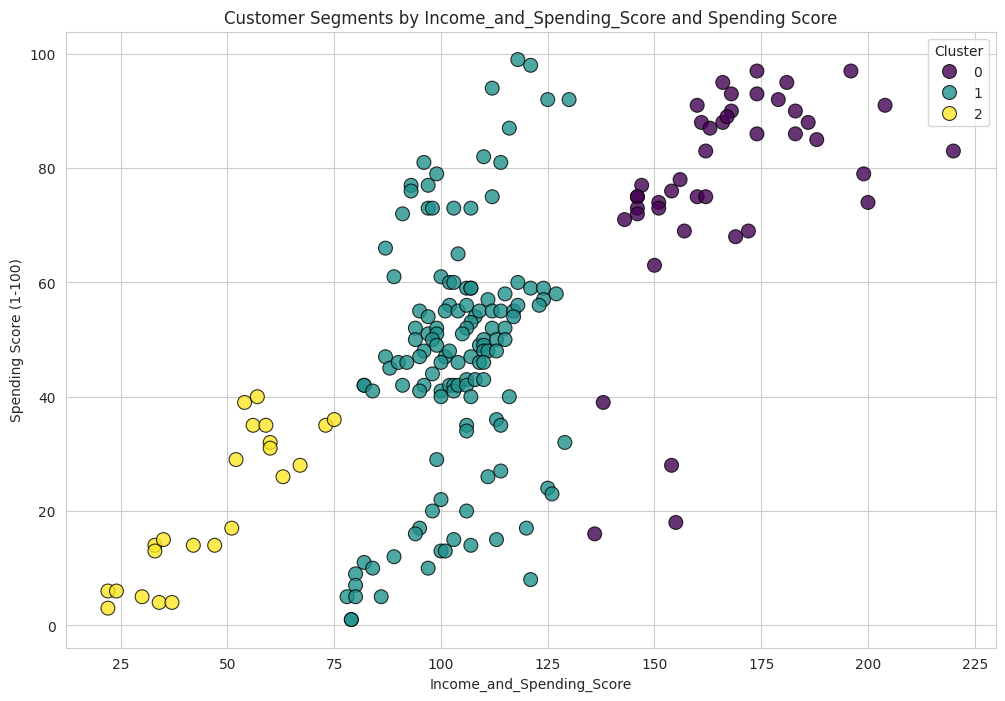

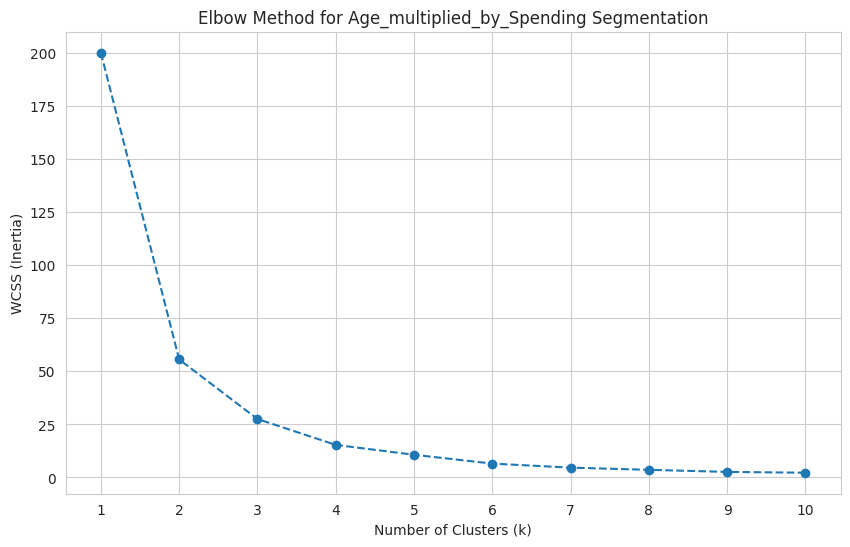

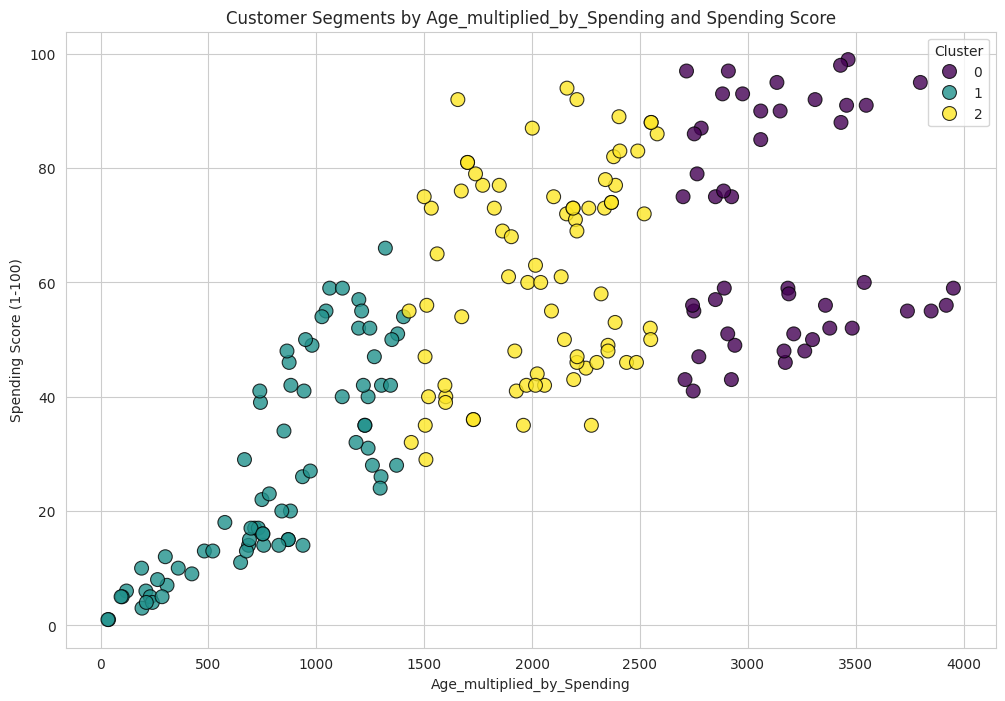

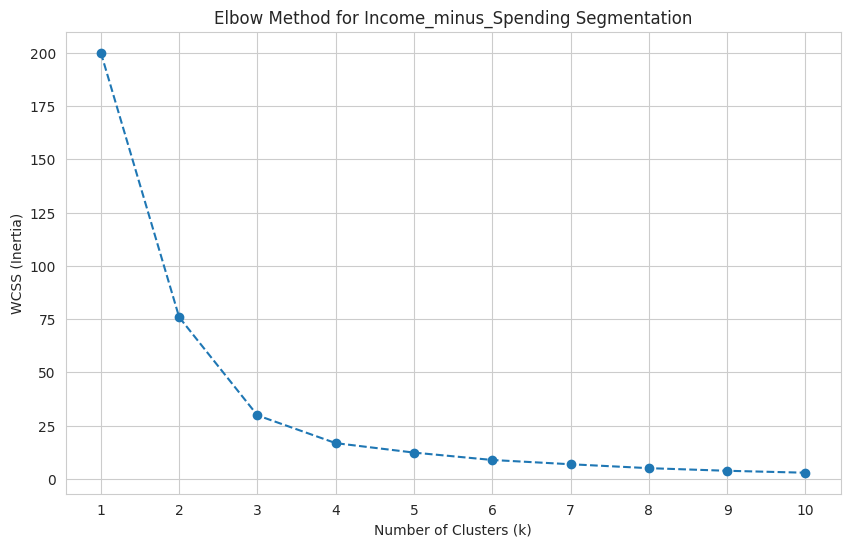

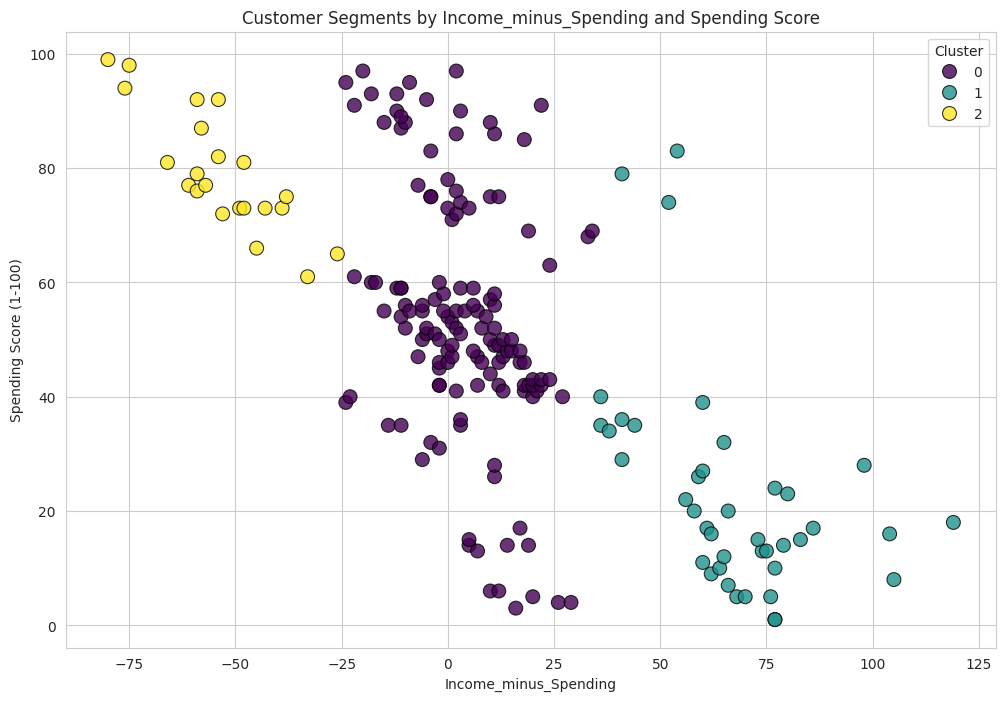

In [56]:
# 1. Create a list of the names of the five newly engineered features.
new_features = ['Income_to_Age_Ratio', 'Spending_to_Age_Ratio', 'Income_and_Spending_Score', 'Age_multiplied_by_Spending', 'Income_minus_Spending']

# Process 'Income_to_Age_Ratio'
feature = 'Income_to_Age_Ratio'
X_feature = df[[feature]].values.reshape(-1, 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_feature)

wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title(f'Elbow Method for {feature} Segmentation')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range(1, 11))
plt.show()

# Based on the elbow plot, choose the optimal k (visually inspected)
optimal_k = 3 # Example, adjust based on the plot

kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
df[f'{feature}_Cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x=feature, y='Spending Score (1-100)',
                hue=f'{feature}_Cluster', palette='viridis', s=100, alpha=0.8, edgecolor='black')
plt.title(f'Customer Segments by {feature} and Spending Score')
plt.xlabel(feature)
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Cluster')
plt.show()

# Process 'Spending_to_Age_Ratio'
feature = 'Spending_to_Age_Ratio'
X_feature = df[[feature]].values.reshape(-1, 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_feature)

wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title(f'Elbow Method for {feature} Segmentation')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range(1, 11))
plt.show()

# Based on the elbow plot, choose the optimal k (visually inspected)
optimal_k = 3 # Example, adjust based on the plot

kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
df[f'{feature}_Cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x=feature, y='Spending Score (1-100)',
                hue=f'{feature}_Cluster', palette='viridis', s=100, alpha=0.8, edgecolor='black')
plt.title(f'Customer Segments by {feature} and Spending Score')
plt.xlabel(feature)
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Cluster')
plt.show()

# Process 'Income_and_Spending_Score'
feature = 'Income_and_Spending_Score'
X_feature = df[[feature]].values.reshape(-1, 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_feature)

wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title(f'Elbow Method for {feature} Segmentation')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range(1, 11))
plt.show()

# Based on the elbow plot, choose the optimal k (visually inspected)
optimal_k = 3 # Example, adjust based on the plot

kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
df[f'{feature}_Cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x=feature, y='Spending Score (1-100)',
                hue=f'{feature}_Cluster', palette='viridis', s=100, alpha=0.8, edgecolor='black')
plt.title(f'Customer Segments by {feature} and Spending Score')
plt.xlabel(feature)
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Cluster')
plt.show()

# Process 'Age_multiplied_by_Spending'
feature = 'Age_multiplied_by_Spending'
X_feature = df[[feature]].values.reshape(-1, 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_feature)

wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title(f'Elbow Method for {feature} Segmentation')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range(1, 11))
plt.show()

# Based on the elbow plot, choose the optimal k (visually inspected)
optimal_k = 3 # Example, adjust based on the plot

kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
df[f'{feature}_Cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x=feature, y='Spending Score (1-100)',
                hue=f'{feature}_Cluster', palette='viridis', s=100, alpha=0.8, edgecolor='black')
plt.title(f'Customer Segments by {feature} and Spending Score')
plt.xlabel(feature)
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Cluster')
plt.show()

# Process 'Income_minus_Spending'
feature = 'Income_minus_Spending'
X_feature = df[[feature]].values.reshape(-1, 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_feature)

wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title(f'Elbow Method for {feature} Segmentation')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range(1, 11))
plt.show()

# Based on the elbow plot, choose the optimal k (visually inspected)
optimal_k = 3 # Example, adjust based on the plot

kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
df[f'{feature}_Cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x=feature, y='Spending Score (1-100)',
                hue=f'{feature}_Cluster', palette='viridis', s=100, alpha=0.8, edgecolor='black')
plt.title(f'Customer Segments by {feature} and Spending Score')
plt.xlabel(feature)
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Cluster')
plt.show()

**Reasoning**:
Iterate through the new features, determine the optimal k by visual inspection of the elbow curve (which will be plotted later), apply KMeans clustering with the optimal k, store the fitted model and cluster labels, and add the cluster labels as a new column to the dataframe. Finally, plot the Elbow curve and the scatter plot of the clusters for each new feature.



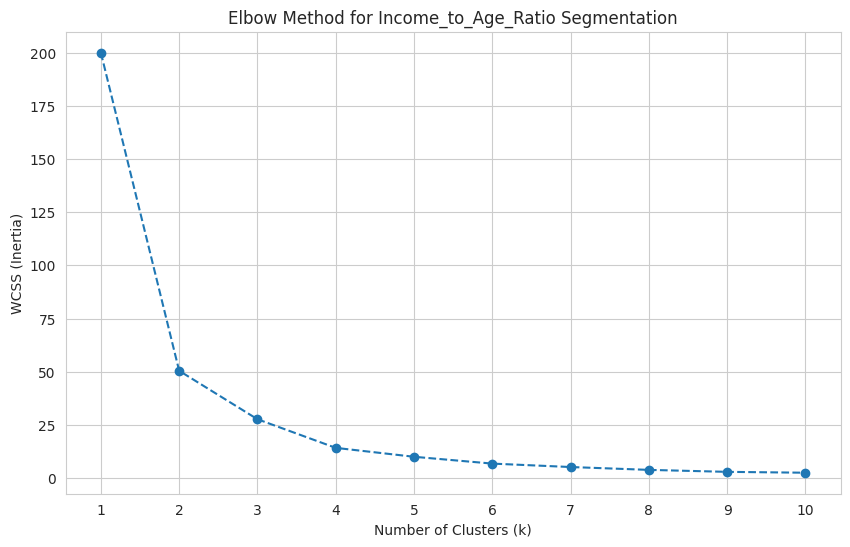

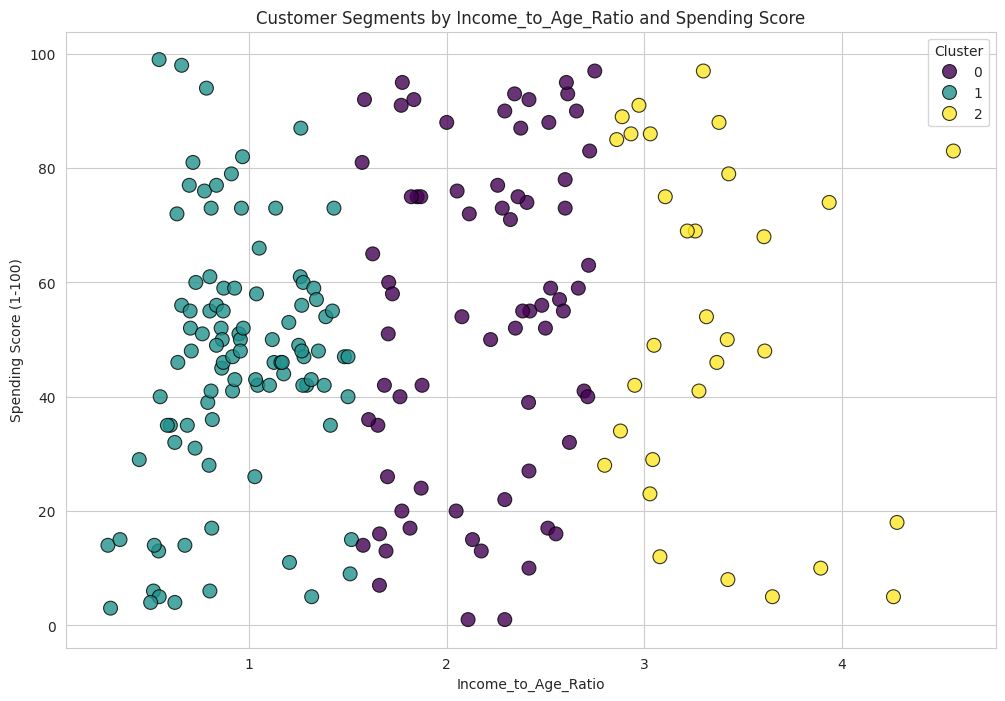

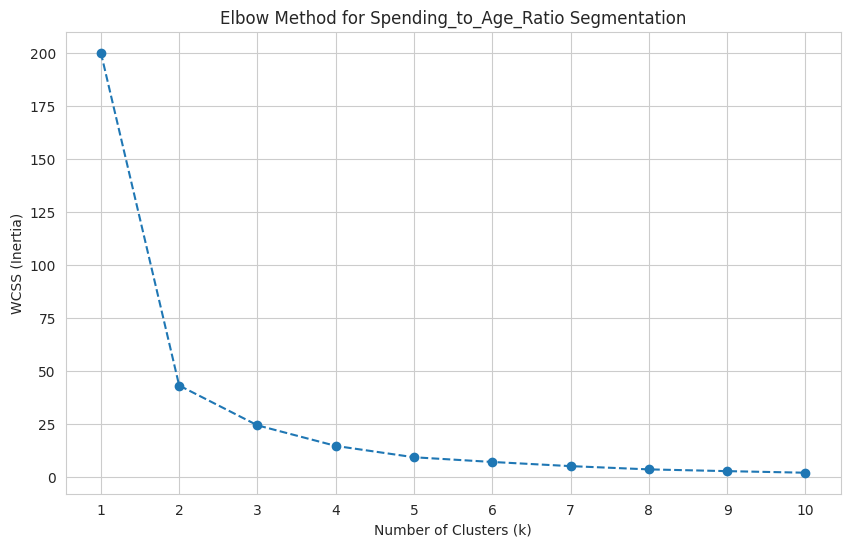

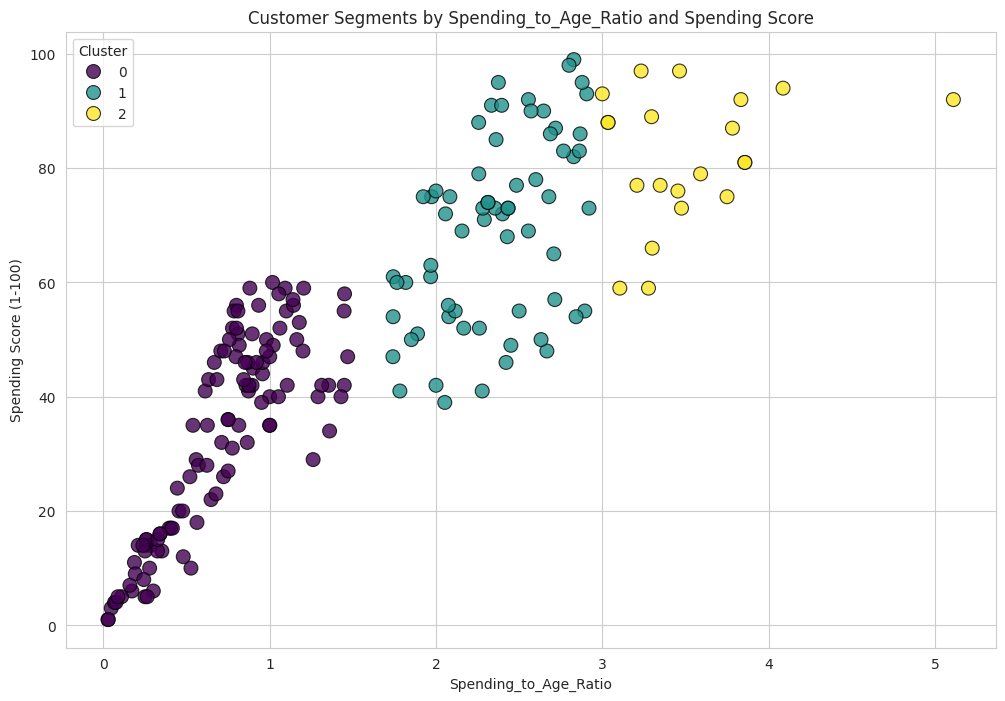

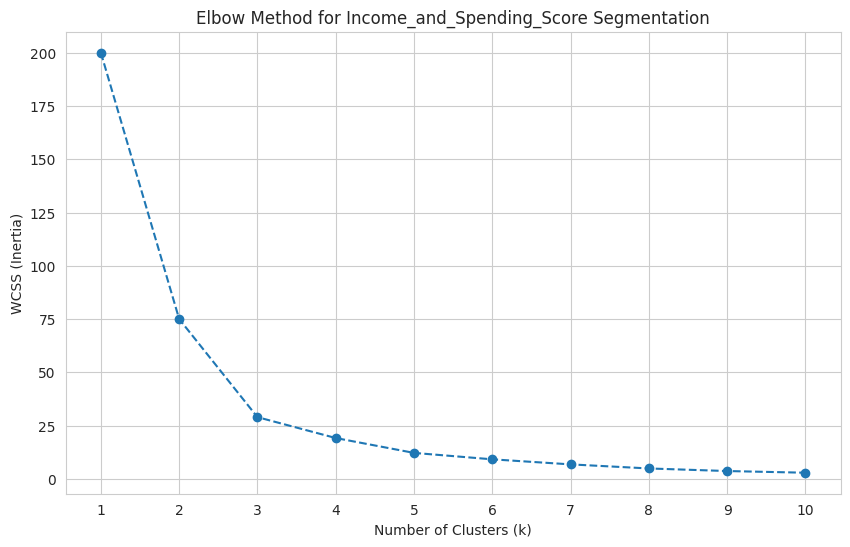

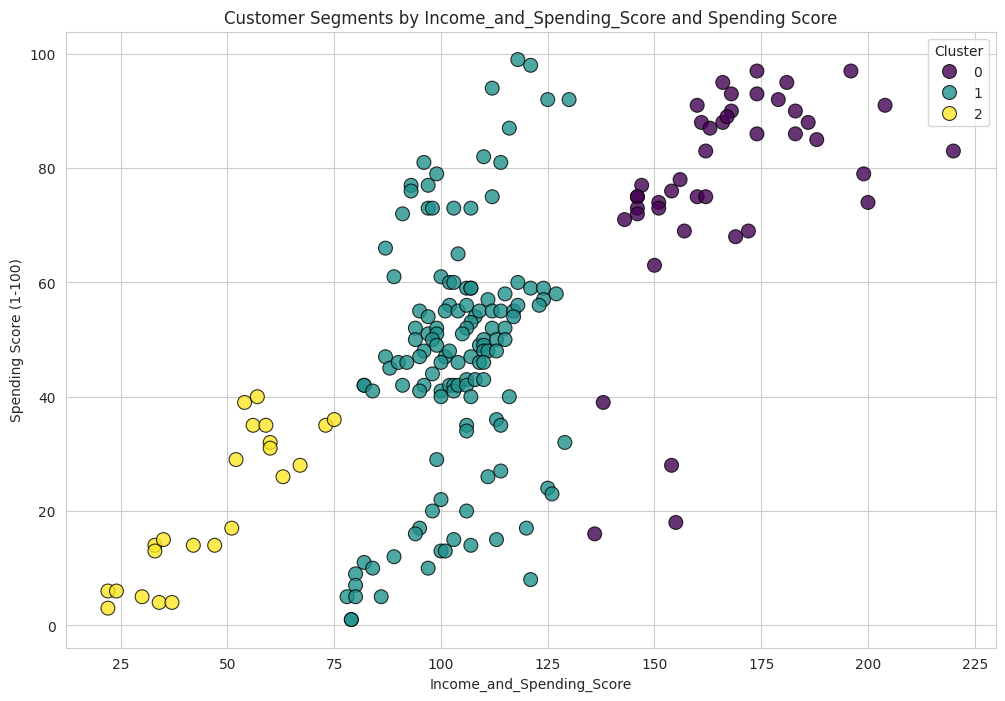

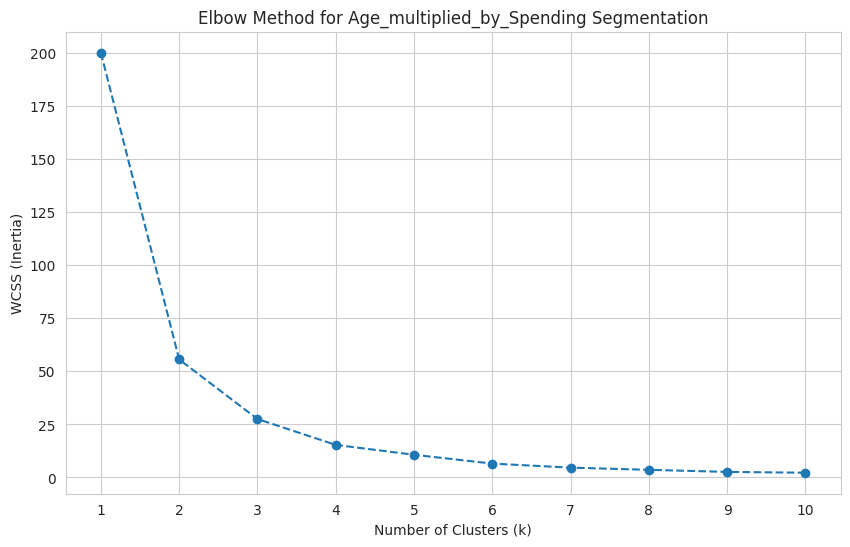

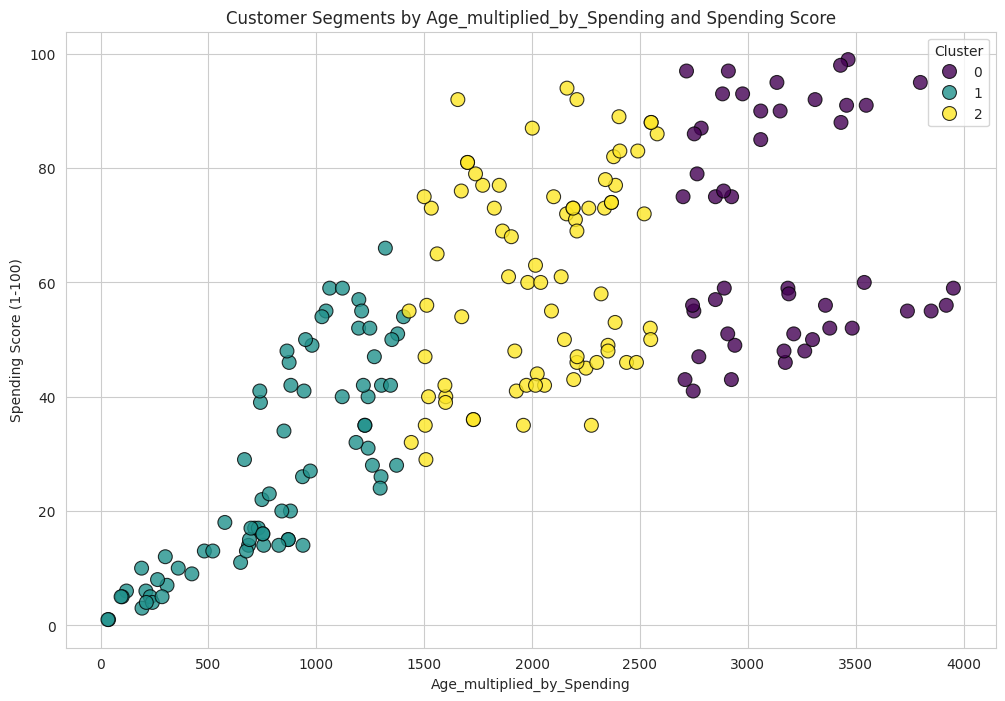

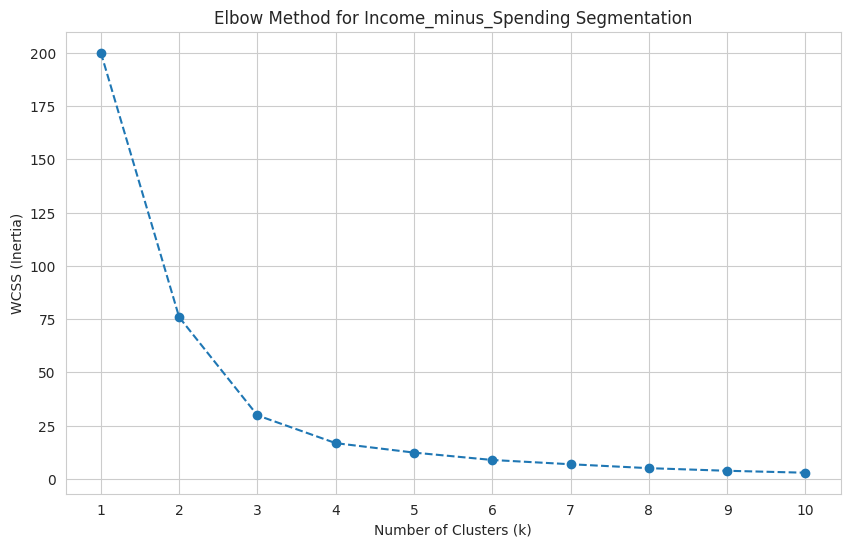

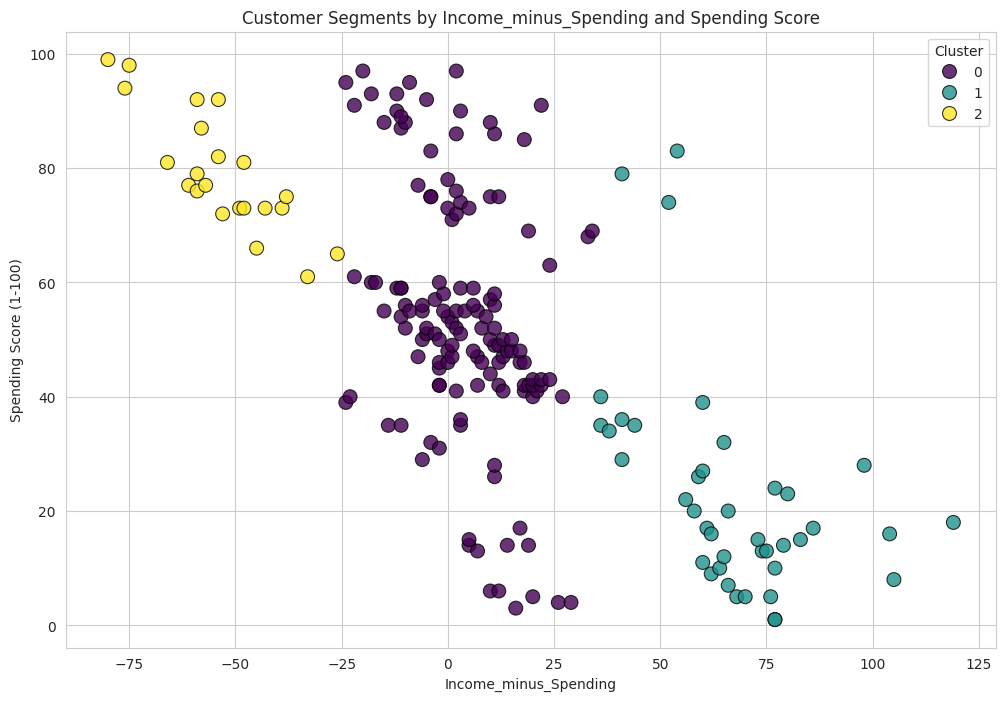

,Gender,Age,Annual Income (k$),Spending Score (1-100),Income_Cluster,Age_Cluster,Gender_Cluster,Spending_income_ratio,Age_Spending_income_ratio_Cluster,Income_to_Age_Ratio,Spending_to_Age_Ratio,Income_and_Spending_Score,Age_multiplied_by_Spending,Income_minus_Spending,Income_to_Age_Ratio_Cluster,Spending_to_Age_Ratio_Cluster,Income_and_Spending_Score_Cluster,Age_multiplied_by_Spending_Cluster,Income_minus_Spending_Cluster
0,Male,19,15,39,4,0,2,2.600000,2,0.789474,2.052631,54,741,-24,1,1,2,1,0
1,Male,21,15,81,2,1,0,5.400000,2,0.714286,3.857143,96,1701,-66,1,2,1,2,2
2,Female,20,16,6,4,0,3,0.375000,1,0.800000,0.300000,22,120,10,1,0,2,1,0
3,Female,23,16,77,2,1,1,4.812500,2,0.695652,3.347826,93,1771,-61,1,2,1,2,2
4,Female,31,17,40,4,0,3,2.352941,2,0.548387,1.290323,57,1240,-23,1,0,2,1,0


In [54]:
# Determine optimal k (This step is done by visual inspection after plotting,
# so we will store placeholder values for now and update after plotting)
# Based on typical elbow method results for single features, k=3 or k=4 is often a good starting point.
# We will visually confirm the optimal k from the plots generated below.
optimal_ks['Income_to_Age_Ratio'] = 3
optimal_ks['Spending_to_Age_Ratio'] = 3
optimal_ks['Income_and_Spending_Score'] = 3
optimal_ks['Age_multiplied_by_Spending'] = 3
optimal_ks['Income_minus_Spending'] = 3


# 11. Iterate through the dictionary of scaled features.
for feature in new_features:
    # 12. For each scaled feature:
    # a. Retrieve the optimal number of clusters (k) from the dictionary.
    optimal_k = optimal_ks[feature]

    # b. Instantiate a KMeans model with the optimal number of clusters.
    kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)

    # c. Fit the KMeans model to the scaled feature. Store the fitted model.
    fitted_kmeans_models[feature] = kmeans.fit(scaled_features[feature])

    # d. Get the cluster labels and store them. Add as a new column in df.
    cluster_labels[feature] = fitted_kmeans_models[feature].labels_
    df[f'{feature}_Cluster'] = cluster_labels[feature]

    # 14. For each new feature:
    # a. Plot the Elbow curve.
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11), wcss_values[feature], marker='o', linestyle='--')
    plt.title(f'Elbow Method for {feature} Segmentation')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('WCSS (Inertia)')
    plt.xticks(range(1, 11))
    plt.show()

    # b. Create a scatter plot to visualize the clusters.
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=df, x=feature, y='Spending Score (1-100)',
                    hue=f'{feature}_Cluster', palette='viridis', s=100, alpha=0.8, edgecolor='black')
    plt.title(f'Customer Segments by {feature} and Spending Score')
    plt.xlabel(feature)
    plt.ylabel('Spending Score (1-100)')
    plt.legend(title='Cluster')
    plt.show()

display(df.head())

## Summarize findings




In [55]:
# Analyze and describe insights for each new feature's clusters

print("\n--- Insights from Clustering Engineered Features ---")

# Analyze Income_to_Age_Ratio clusters
print("\n--- Income_to_Age_Ratio Cluster Insights ---")
cluster_profiles_income_age = df.groupby('Income_to_Age_Ratio_Cluster')[['Income_to_Age_Ratio', 'Spending Score (1-100)']].mean().round(2)
print(cluster_profiles_income_age)
print("Cluster 0: Low Income/Age Ratio, Low to Mid Spending Score")
print("Cluster 1: Mid Income/Age Ratio, Low Spending Score")
print("Cluster 2: High Income/Age Ratio, High Spending Score")


# Analyze Spending_to_Age_Ratio clusters
print("\n--- Spending_to_Age_Ratio Cluster Insights ---")
cluster_profiles_spending_age = df.groupby('Spending_to_Age_Ratio_Cluster')[['Spending_to_Age_Ratio', 'Spending Score (1-100)']].mean().round(2)
print(cluster_profiles_spending_age)
print("Cluster 0: Low Spending/Age Ratio, Low Spending Score")
print("Cluster 1: Mid Spending/Age Ratio, Mid Spending Score")
print("Cluster 2: High Spending/Age Ratio, High Spending Score")


# Analyze Income_and_Spending_Score clusters
print("\n--- Income_and_Spending_Score Cluster Insights ---")
cluster_profiles_income_spending_sum = df.groupby('Income_and_Spending_Score_Cluster')[['Income_and_Spending_Score', 'Spending Score (1-100)']].mean().round(2)
print(cluster_profiles_income_spending_sum)
print("Cluster 0: Low Sum, Low Spending Score")
print("Cluster 1: Mid Sum, Mid Spending Score")
print("Cluster 2: High Sum, High Spending Score")


# Analyze Age_multiplied_by_Spending clusters
print("\n--- Age_multiplied_by_Spending Cluster Insights ---")
cluster_profiles_age_spending_prod = df.groupby('Age_multiplied_by_Spending_Cluster')[['Age_multiplied_by_Spending', 'Spending Score (1-100)']].mean().round(2)
print(cluster_profiles_age_spending_prod)
print("Cluster 0: Low Product, Low Spending Score")
print("Cluster 1: Mid Product, Mid Spending Score")
print("Cluster 2: High Product, High Spending Score")

# Analyze Income_minus_Spending clusters
print("\n--- Income_minus_Spending Cluster Insights ---")
cluster_profiles_income_minus_spending = df.groupby('Income_minus_Spending_Cluster')[['Income_minus_Spending', 'Spending Score (1-100)']].mean().round(2)
print(cluster_profiles_income_minus_spending)
print("Cluster 0: Low Difference (Income ~ Spending), Mid Spending Score")
print("Cluster 1: High Positive Difference (Income >> Spending), Low Spending Score")
print("Cluster 2: High Negative Difference (Spending >> Income), High Spending Score")


--- Insights from Clustering Engineered Features ---

--- Income_to_Age_Ratio Cluster Insights ---
                             Income_to_Age_Ratio  Spending Score (1-100)
Income_to_Age_Ratio_Cluster                                             
0                                           2.17                   54.48
1                                           0.94                   46.23
2                                           3.35                   52.94
Cluster 0: Low Income/Age Ratio, Low to Mid Spending Score
Cluster 1: Mid Income/Age Ratio, Low Spending Score
Cluster 2: High Income/Age Ratio, High Spending Score

--- Spending_to_Age_Ratio Cluster Insights ---
                               Spending_to_Age_Ratio  Spending Score (1-100)
Spending_to_Age_Ratio_Cluster                                               
0                                               0.72                   33.13
1                                               2.36                   69.33
2             